# 環境確認

In [ ]:
import sys
import torch

print("Pythonのバージョン：",sys.version)
print("PyTorchのバージョン：", torch.__version__)
print("使用しているGPUの確認")
!nvidia-smi

Pythonのバージョン： 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
PyTorchのバージョン： 1.10.0+cu111
使用しているGPUの確認
Tue Feb 22 01:48:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    57W / 149W |   4874MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----

# データのダウンロード

In [ ]:
# データのダウンロード
!wget https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938130-1629953152/screw.tar.xz

--2022-02-22 01:48:13--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938130-1629953152/screw.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195344332 (186M) [application/x-xz]
Saving to: ‘screw.tar.xz.1’

screw.tar.xz.1      100%[===================>] 186.29M  18.6MB/s    in 11s     

2022-02-22 01:48:25 (17.1 MB/s) - ‘screw.tar.xz.1’ saved [195344332/195344332]



In [ ]:
# 解凍
!tar -xf screw.tar.xz

In [ ]:
# 作業ディレクトリを確認
!ls

results  sample_data  screw  screw.tar.xz  screw.tar.xz.1


# テストデータの準備

In [ ]:
# テストデータのディレクトリを確認
!ls screw/test/

good  manipulated_front  scratch_head  scratch_neck  thread_side  thread_top


In [ ]:
# testディレクトリ内のディレクトリ内の画像リストを作成
import glob

good = glob.glob('screw/test/good/*.png')
manipulated_front = glob.glob('screw/test/manipulated_front/*.png')
scratch_head = glob.glob('screw/test/scratch_head/*.png')
scratch_neck = glob.glob('screw/test/scratch_neck/*.png')
thread_side = glob.glob('screw/test/thread_side/*.png')
thread_top = glob.glob('screw/test/thread_top/*.png')
print(good)
print(len(good))

['screw/test/good/008.png', 'screw/test/good/017.png', 'screw/test/good/036.png', 'screw/test/good/037.png', 'screw/test/good/002.png', 'screw/test/good/020.png', 'screw/test/good/022.png', 'screw/test/good/038.png', 'screw/test/good/003.png', 'screw/test/good/025.png', 'screw/test/good/000.png', 'screw/test/good/018.png', 'screw/test/good/007.png', 'screw/test/good/031.png', 'screw/test/good/005.png', 'screw/test/good/040.png', 'screw/test/good/035.png', 'screw/test/good/034.png', 'screw/test/good/013.png', 'screw/test/good/015.png', 'screw/test/good/024.png', 'screw/test/good/019.png', 'screw/test/good/027.png', 'screw/test/good/009.png', 'screw/test/good/016.png', 'screw/test/good/011.png', 'screw/test/good/029.png', 'screw/test/good/033.png', 'screw/test/good/014.png', 'screw/test/good/012.png', 'screw/test/good/023.png', 'screw/test/good/039.png', 'screw/test/good/006.png', 'screw/test/good/001.png', 'screw/test/good/028.png', 'screw/test/good/004.png', 'screw/test/good/026.png', 

# 事前準備

In [ ]:
# ライブラリのインポート
import os
import random
from glob import glob
from warnings import filterwarnings

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn.init as init
from natsort import natsorted
from PIL import Image
from skimage import io, transform
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

from torchsummary import summary

filterwarnings("ignore")  # warningをオフにする

# ランダムシードの設定
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [ ]:
'''デバイスの設定'''

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
'''初期設定'''

COLAB_FLG = False  # COLABで実行する場合はTrue, それ以外で実行する場合はFalse

if COLAB_FLG:
    from google.colab import drive
    drive.mount('/content/gdrive') # マウント先
    ATTACH_PATH = "/content/gdrive/MyDrive/screw_anomaly"  # 保存先のベースディレクトリ
else:
    ATTACH_PATH = "."  # ローカルならカレントディレクトリ
    
    
SAVE_MODEL_PATH = f"{ATTACH_PATH}/results/model/"  # モデルの保存先
SAVE_IMAGE_FROM_Z_PATH = f"{ATTACH_PATH}/results/image/image_from_z/"  # 乱数から生成した画像の保存先
SAVE_IMAGE_RECONSTRUCT = f"{ATTACH_PATH}/results/image/RECONSTRUCT/"  # 再構成した画像の保存先

# 保存先のディレクトリを作成する
os.makedirs(SAVE_MODEL_PATH, exist_ok=True)
os.makedirs(SAVE_IMAGE_FROM_Z_PATH, exist_ok=True)
os.makedirs(SAVE_IMAGE_RECONSTRUCT, exist_ok=True)

In [ ]:
'''ハイパーパラメータの設定'''

import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--image_size", type=int, default=192)
parser.add_argument("--num_epochs", type=int, default=1000)
parser.add_argument("--batch_size", type=int, default=16)
parser.add_argument("--lr", type=float, default=4e-4)
parser.add_argument("--z_dim", type=int, default=128) # ノイズの次元
parser.add_argument("--beta1", type=float, default=0.5) # Adamのハイパーパラメータ
parser.add_argument("--beta2", type=float, default=0.999) # Adamのハイパーパラメータ
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=16, beta1=0.5, beta2=0.999, image_size=192, lr=0.0004, num_epochs=1000, z_dim=128)


In [ ]:
# デバイスの設定
device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {} # GPUが使える場合、DataLoaderでのミニバッチの取り出しを高速化

# DataLoader

In [ ]:
train_root = './screw/train/good/'  # train dataの保存してあるディレクトリ
val_root = './screw/test/good/'  # val dataの保存してあるディレクトリ

# ディレクトリから画像を読み込んでDataLoaderに渡す用のクラス

class LoadFromFolder(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = natsorted(os.listdir(main_dir)) # ディレクトリ一覧を取得して自然ソート
        self.all_imgs_name = natsorted(all_imgs)
        self.imgs_loc = [os.path.join(self.main_dir, i) for i in self.all_imgs_name] # 画像のディレクトリ一覧

    def __len__(self):
        return len(self.all_imgs_name)
    
    def load_image(self, path):
        image = Image.open(path).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image
    
    def __getitem__(self, idx):
        
        # 後ほどsliceで画像を複数枚取得したいのでsliceでも取れるようにする
        if type(idx) == slice:
            paths = self.imgs_loc[idx]
            tensor_image = [self.load_image(path) for path in paths]
            tensor_image = torch.cat(tensor_image).reshape(len(tensor_image), *tensor_image[0].shape)
        elif type(idx) == int:
            path = self.imgs_loc[idx]
            tensor_image = self.load_image(path)
        return tensor_image

# 画像を読み込む際の前処理

transform_dict = {
    "train": transforms.Compose(
        [
            transforms.Resize((opt.image_size, opt.image_size)),  # image_sizeにreshape
            transforms.RandomHorizontalFlip(), # ランダムに左右反転を行う
            transforms.ToTensor(),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize((opt.image_size, opt.image_size)),  # image_sizeにreshape
            transforms.ToTensor(),
        ]
    ),
}

# データを読み込む
train_dataset = LoadFromFolder(train_root, transform=transform_dict["train"])

test_dataset = LoadFromFolder(val_root, transform=transform_dict["test"])

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = opt.batch_size, shuffle=True, **kwargs)

val_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = opt.batch_size, shuffle=True, **kwargs)

# Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1, bias=False), # 96x96
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False), # 48x48
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),  
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False), # 24x24
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),  
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False), # 12x12
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),  
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), # 6x6
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),  
            
            nn.Conv2d(256, 512, kernel_size=6, stride=1, bias=False), # 1x1
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),  
            
            nn.Conv2d(512, 512, kernel_size=1, stride=1, bias=False), # 1x1
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),  
        )

        self.last = nn.Sequential(nn.Conv2d(512, opt.z_dim, kernel_size=1, stride=1, bias=False))

    def forward(self, x):

        out = self.main(x)
        out = self.last(out)
        out = out.view(out.size()[0], -1, 1, 1)
        return out

In [ ]:
# ネットワークを可視化する
summary(Encoder().to(device), (3, opt.image_size, opt.image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 96, 96]             768
       BatchNorm2d-2           [-1, 16, 96, 96]              32
         LeakyReLU-3           [-1, 16, 96, 96]               0
            Conv2d-4           [-1, 32, 48, 48]           8,192
       BatchNorm2d-5           [-1, 32, 48, 48]              64
         LeakyReLU-6           [-1, 32, 48, 48]               0
            Conv2d-7           [-1, 64, 24, 24]          32,768
       BatchNorm2d-8           [-1, 64, 24, 24]             128
         LeakyReLU-9           [-1, 64, 24, 24]               0
           Conv2d-10          [-1, 128, 12, 12]         131,072
      BatchNorm2d-11          [-1, 128, 12, 12]             256
        LeakyReLU-12          [-1, 128, 12, 12]               0
           Conv2d-13            [-1, 256, 6, 6]         524,288
      BatchNorm2d-14            [-1, 25

# Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(opt.z_dim, 512, kernel_size=6, stride=1, padding=0, bias=False), # 3x3
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(512, 256, kernel_size=7, stride=1, padding=0, bias=False), # 6x6
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), # 12x12
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False), # 24x24
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False), # 48x48
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False), #96x96
            nn.Tanh()
        )

    def forward(self, z):
        out = self.main(z)
        return out

In [ ]:
# ネットワークを可視化する
summary(Generator().to(device), tuple([opt.z_dim, 1, 1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 6, 6]       2,359,296
       BatchNorm2d-2            [-1, 512, 6, 6]           1,024
         LeakyReLU-3            [-1, 512, 6, 6]               0
   ConvTranspose2d-4          [-1, 256, 12, 12]       6,422,528
       BatchNorm2d-5          [-1, 256, 12, 12]             512
         LeakyReLU-6          [-1, 256, 12, 12]               0
   ConvTranspose2d-7          [-1, 128, 24, 24]         524,288
       BatchNorm2d-8          [-1, 128, 24, 24]             256
         LeakyReLU-9          [-1, 128, 24, 24]               0
  ConvTranspose2d-10           [-1, 64, 48, 48]         131,072
      BatchNorm2d-11           [-1, 64, 48, 48]             128
        LeakyReLU-12           [-1, 64, 48, 48]               0
  ConvTranspose2d-13           [-1, 32, 96, 96]          32,768
      BatchNorm2d-14           [-1, 32,

# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
            
        self.x_layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True), #96x96
            nn.Dropout2d(p=0.3),

            nn.AvgPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True), #48x48
            nn.Dropout2d(p=0.3),
            
            nn.AvgPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True), #24x24
            nn.Dropout2d(p=0.3),

            nn.AvgPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True), #12x12
            nn.Dropout2d(p=0.3),
            
            nn.AvgPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True), #6x6
            nn.Dropout2d(p=0.3),
            
            nn.AvgPool2d(2),
            nn.Conv2d(256, 256, kernel_size=6, stride=1) #1x1

        )
        self.z_layer = nn.Sequential(
            nn.Conv2d(opt.z_dim, 256, kernel_size=1, stride=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(p=0.2),
        )
        
        self.last1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1, stride=1),
            nn.LeakyReLU(0.1, inplace=False),
            nn.Dropout2d(p=0.2),
        )
        self.last2 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=1, stride=1),
        )

    def forward(self, x, z):
        
        output_x = self.x_layer(x)
        output_z = self.z_layer(z)
        
        concat_x_z = torch.cat((output_x, output_z), 1)
        output = self.last1(concat_x_z)

        feature = output.view(output.size()[0], -1)
        
        output = self.last2(output)
        output = F.sigmoid(output)
        return output.squeeze(), feature

In [ ]:
# ネットワークを可視化する
summary(Discriminator().to(device), [(3, opt.image_size, opt.image_size), (opt.z_dim, 1, 1)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 192, 192]             448
         LeakyReLU-2         [-1, 16, 192, 192]               0
         Dropout2d-3         [-1, 16, 192, 192]               0
         AvgPool2d-4           [-1, 16, 96, 96]               0
            Conv2d-5           [-1, 32, 96, 96]           4,640
       BatchNorm2d-6           [-1, 32, 96, 96]              64
         LeakyReLU-7           [-1, 32, 96, 96]               0
         Dropout2d-8           [-1, 32, 96, 96]               0
         AvgPool2d-9           [-1, 32, 48, 48]               0
           Conv2d-10           [-1, 64, 48, 48]          18,496
      BatchNorm2d-11           [-1, 64, 48, 48]             128
        LeakyReLU-12           [-1, 64, 48, 48]               0
        Dropout2d-13           [-1, 64, 48, 48]               0
        AvgPool2d-14           [-1, 64,

In [ ]:
# 重みの初期化を行う関数

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find("Linear") != -1:
        m.bias.data.fill_(0)

E = Encoder().to(device)
E.apply(weights_init)

G = Generator().to(device)
G.apply(weights_init)

D = Discriminator().to(device)
D.apply(weights_init)

Discriminator(
  (x_layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Dropout2d(p=0.3, inplace=False)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1, inplace=True)
    (7): Dropout2d(p=0.3, inplace=False)
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.1, inplace=True)
    (12): Dropout2d(p=0.3, inplace=False)
    (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(128, eps

In [ ]:
criterion = nn.BCELoss()  # 評価関数
criterion_L1 = nn.L1Loss(reduction="sum") # 異常スコア計測用

In [ ]:
# gとeは共通のoptimizer
optimizer_ge = torch.optim.Adam(list(G.parameters()) + list(E.parameters()), lr=opt.lr, betas=(opt.beta1,opt.beta2))
optimizer_d = torch.optim.Adam(D.parameters(), lr=opt.lr, betas=(opt.beta1,opt.beta2))

scheduler_ge = torch.optim.lr_scheduler.StepLR(optimizer_ge, step_size=50, gamma=0.9)
scheduler_d = torch.optim.lr_scheduler.StepLR(optimizer_d, step_size=50, gamma=0.9)

In [ ]:
def Anomaly_score(x, E_x, G_E_x, Lambda=0.1):
    
    _,x_feature = D(x, E_x)
    _,G_E_x_feature = D(G_E_x, E_x)
    
    residual_loss = criterion_L1(x, G_E_x)
    discrimination_loss = criterion_L1(x_feature, G_E_x_feature)
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    total_loss = total_loss.item()

    return total_loss

# 学習

In [ ]:
Losses_D = []
Losses_GE = []
anomaly_scores = []

for epoch in range(opt.num_epochs):
    loss_d_sum = 0
    loss_ge_sum = 0
    anomaly_score_sum = 0
    
    for i,(x, x_val) in enumerate(zip(train_loader, val_loader)):
        
        G.train()
        D.train()
        E.train()

        # 値の設定
        y_true = Variable(torch.ones(x.size()[0])).to(device)
        y_fake = Variable(torch.zeros(x.size()[0])).to(device)
        
        x = Variable(x).to(device)
        z = Variable(init.normal(torch.Tensor(x.size()[0],opt.z_dim, 1, 1),mean=0,std=0.1)).to(device)
        
        # Discriminatorに対するノイズ
        noise1 = Variable(torch.Tensor(x.size()).normal_(0, 0.1 * (opt.num_epochs - epoch) / opt.num_epochs),
                          requires_grad=False).to(device)
        noise2 = Variable(torch.Tensor(x.size()).normal_(0, 0.1 * (opt.num_epochs - epoch) / opt.num_epochs),
                          requires_grad=False).to(device)

        # Discriminator
        optimizer_d.zero_grad()
        
        E_x = E(x) 
        p_true, _ = D(x + noise1, E_x)
        
        G_z = G(z)
        p_fake, _ = D(G_z + noise2, z)
        
        loss_d = criterion(p_true, y_true) + criterion(p_fake, y_fake)
        loss_d.backward(retain_graph=True)
        optimizer_d.step()
        
        # Generator, Encoder
        optimizer_ge.zero_grad()
        
        G_E_x = G(E_x)
        E_G_z = E(G_z)
    
        p_true, _ = D(x + noise1, E_x)
        
        # G_z = model_G(z)
        p_fake, _ = D(G_z + noise2, z)
        
        
        loss_ge_1 = criterion(p_fake, y_true) + criterion(p_true, y_fake)
        loss_ge_2 = criterion_L1(x, G_E_x) +  criterion_L1(z, E_G_z)
        
        alpha = 0.01
        
        loss_ge = (1 - alpha)*loss_ge_1 + alpha*loss_ge_2
        loss_ge.backward(retain_graph=True)
        optimizer_ge.step()
        
        loss_d_sum += loss_d.item()
        loss_ge_sum += loss_ge.item()
        
        # anomaly scoreの記録
        
        G.eval()
        D.eval()
        E.eval()
        x_val = Variable(x_val).to(device)
        E_x_val = E(x_val)
        G_E_x_val = G(E_x_val)
        anomaly_score_sum += Anomaly_score(x_val, E_x_val, G_E_x_val)

        # 画像を保存
        if i == 0:
            
            G.eval()
            D.eval()
            E.eval()
        
            save_image_size_for_z = min(opt.batch_size, 8)
            save_images = G(z)
            save_image(save_images[:save_image_size_for_z], f"{SAVE_IMAGE_FROM_Z_PATH}/epoch_{epoch}.png", nrow=4)

            save_image_size_for_recon = min(opt.batch_size, 8)
            images = x[:save_image_size_for_recon]
            G_E_x = G(E(images))
            diff_images = torch.abs(images - G_E_x)
            comparison = torch.cat([images , G_E_x, diff_images]).to("cpu")
            save_image(comparison, f"{SAVE_IMAGE_RECONSTRUCT}/epoch_{epoch}.png", nrow=save_image_size_for_recon)
            
    scheduler_ge.step()
    scheduler_d.step()
        
    # lossを記録
    loss_d_mean = loss_d_sum / len(train_loader)
    loss_ge_mean = loss_ge_sum / len(train_loader)
    anomaly_score_mean = anomaly_score_sum / len(train_loader)
    
    print(f"{epoch}/{opt.num_epochs} epoch ge_loss: {loss_ge_mean:.3f} d_loss: {loss_d_mean:.3f} anomaly_score: {anomaly_score_mean:.3f}")
    
    Losses_D.append(loss_d_mean)
    Losses_GE.append(loss_ge_mean)
    anomaly_scores.append(anomaly_score_mean)
    
    # モデルを保存
    if (epoch + 1) % 10 == 0:
        torch.save(G.state_dict(),f'{SAVE_MODEL_PATH}/Generator_{epoch + 1}.pkl')
        torch.save(E.state_dict(),f'{SAVE_MODEL_PATH}/Encoder_{epoch + 1}.pkl')
        torch.save(D.state_dict(),f'{SAVE_MODEL_PATH}/Discriminator_{epoch + 1}.pkl')

0/1000 epoch ge_loss: 1841.191 d_loss: 0.209 anomaly_score: 135729.069
1/1000 epoch ge_loss: 1710.256 d_loss: 0.199 anomaly_score: 132162.219
2/1000 epoch ge_loss: 1552.024 d_loss: 0.197 anomaly_score: 122104.156
3/1000 epoch ge_loss: 1403.037 d_loss: 0.169 anomaly_score: 106321.975
4/1000 epoch ge_loss: 1221.034 d_loss: 0.151 anomaly_score: 88080.133
5/1000 epoch ge_loss: 1078.289 d_loss: 0.123 anomaly_score: 70516.584
6/1000 epoch ge_loss: 933.178 d_loss: 0.106 anomaly_score: 55247.609
7/1000 epoch ge_loss: 779.029 d_loss: 0.089 anomaly_score: 40278.930
8/1000 epoch ge_loss: 675.835 d_loss: 0.080 anomaly_score: 31214.280
9/1000 epoch ge_loss: 561.942 d_loss: 0.115 anomaly_score: 27619.443
10/1000 epoch ge_loss: 478.983 d_loss: 0.089 anomaly_score: 25131.854
11/1000 epoch ge_loss: 405.186 d_loss: 0.078 anomaly_score: 22929.412
12/1000 epoch ge_loss: 333.459 d_loss: 0.064 anomaly_score: 20139.121
13/1000 epoch ge_loss: 283.752 d_loss: 0.061 anomaly_score: 20609.637
14/1000 epoch ge_los

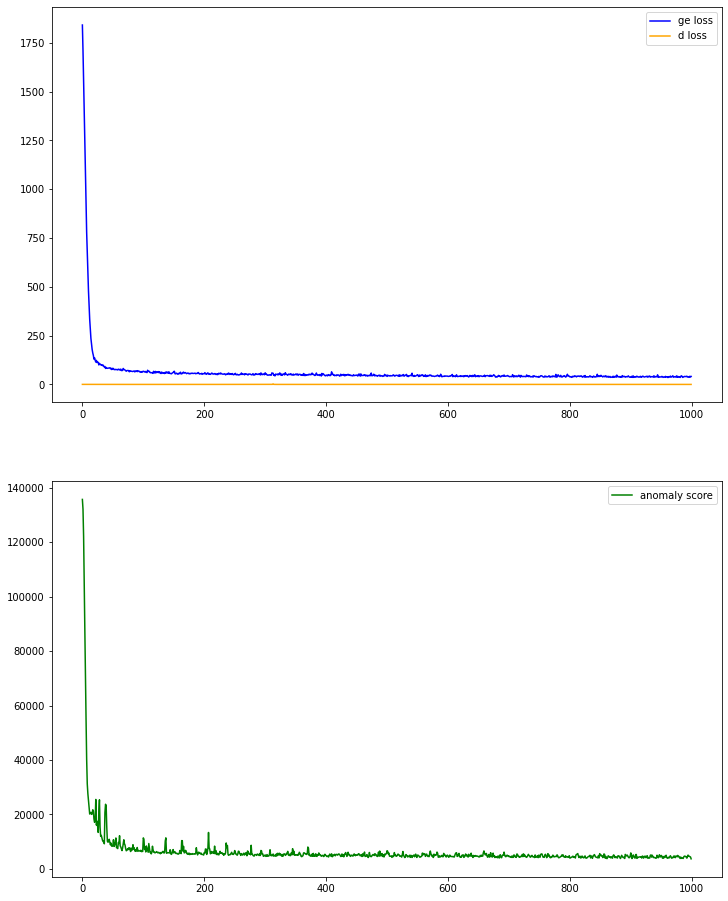

In [ ]:
# Generator+EncoderとDiscriminatorのLossの推移と、anomaly scoreの推移
plt.figure(figsize=(12, 8*2))

plt.subplot(211)
plt.plot(range(len(Losses_GE)), Losses_GE, label="ge loss",color="blue")
plt.legend()

plt.plot(range(len(Losses_D)), Losses_D, label="d loss",color="orange")
plt.legend()
plt.subplot(212)
plt.plot(range(len(anomaly_scores)), anomaly_scores, label="anomaly score",color="green")
plt.legend()

plt.show()

# 潜在変数Zの最適化とテスト画像での異常検知

In [ ]:
# 学習したモデルの読み込み

LOAD_EPOCH = 1000

G = Generator().to(device)
G.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Generator_{LOAD_EPOCH}.pkl"))
G.eval()


E = Encoder().to(device)
E.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Encoder_{LOAD_EPOCH}.pkl"))
E.eval()

D = Discriminator().to(device)
D.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Discriminator_{LOAD_EPOCH}.pkl"))
D.eval()
print("load model")

load model


In [ ]:
# 正常な画像で実行

random_image_size = 40

test_root_normal = './screw/test/good/'
test_dataset_normal = LoadFromFolder(test_root_normal, transform=transform_dict["test"])

test_images_normal = random.sample(list(test_dataset_normal), random_image_size)

normal_anomaly_score = []

# うまく再現され、異常スコアが低くなっていれば成功
for idx in range(len(test_images_normal)):

    x = test_images_normal[idx].view(1, 3, 192, 192).to(device)
    E_x = E(x)
    G_E_x = G(E_x)
    
    loss = Anomaly_score(x, E_x, G_E_x)
    normal_anomaly_score.append(loss)
    diff_img = torch.abs(x - G_E_x)
    print(f"Anomaly_score: {loss:.3f}")
    comparison = torch.cat([x.to("cpu"), G_E_x.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    
    plt.figure(figsize=(12, 4))
    plt.imshow((joined_image * 255).astype(np.uint8))
    plt.show()

In [ ]:
# manipulated_frontで実行

random_image_size = 20

test_root_manipulated_front = './screw/test/manipulated_front/'
test_dataset_manipulated_front = LoadFromFolder(test_root_manipulated_front, transform=transform_dict["test"])

test_images_manipulated_front = random.sample(list(test_dataset_manipulated_front), random_image_size)

manipulated_front_anomaly_score = []

# うまく再現され、異常スコアが低くなっていれば成功
for idx in range(len(test_images_manipulated_front)):

    x = test_images_manipulated_front[idx].view(1, 3, 192, 192).to(device)
    E_x = E(x)
    G_E_x = G(E_x)
    
    loss = Anomaly_score(x, E_x, G_E_x)
    manipulated_front_anomaly_score.append(loss)
    diff_img = torch.abs(x - G_E_x)
    print(f"Anomaly_score: {loss:.3f}")
    comparison = torch.cat([x.to("cpu"), G_E_x.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    
    plt.figure(figsize=(12, 4))
    plt.imshow((joined_image * 255).astype(np.uint8))
    plt.show()

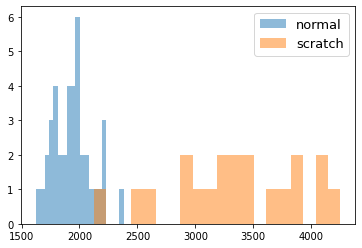

In [ ]:
# 正常品のスコアをデータフレーム化
normal_df = pd.DataFrame({'score': normal_anomaly_score})
normal_df['label'] = 'normal'

# 傷品のスコアをデータフレーム化
manipulated_front_df = pd.DataFrame({'score': manipulated_front_anomaly_score})
manipulated_front_df['label'] = 'scratch'

#テストデータのlossを可視化
plt.hist(normal_df['score'], alpha=0.5, bins=20, label='normal')
plt.hist(manipulated_front_df['score'], alpha=0.5, bins=20, label='scratch')
plt.legend(loc="upper right", fontsize=13)
plt.show()